#### Benchmaking Experiment 006b
- benchmarking model architecture -3 with PAMAP2, DaLiAc and UTD-MHAD datasets
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [50]:
import os
import pickle
from datetime import date
from tqdm.autonotebook import tqdm
from copy import deepcopy
import numpy as np
import pandas as pd
import json

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import numpy.random as random
from src.datasets.data import PAMAP2ReaderV2
from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

# from src.running import train_step1, eval_step1

In [19]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001",
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "model_params": {
        "linear_filters": [1024, 1024, 1024, 400],
        "input_feat": 36,
        "dropout": 0.1,
    },
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 64,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [20]:
def save_model(model, model_name, unique_name, fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)
    torch.save({
        "n_epochs": config["n_epochs"],
        "model_state_dict": model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")


model_iden = "fold"
notebook_iden = "SORTModel_logits"
models_saves = "model_saves"

In [21]:
dataReader = PAMAP2ReaderV2('data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


D:\FYP\HAR-ZSL-XAI\src\datasets\data.py:525: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


[ 1  2  3  4  5  6  7  9 10 11 12 13 16 17 18 19 20 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


---
Model Building

In [22]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024, 1024, 1024, 2048], input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat, linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0], linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1], linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2] + linear_filters[1] + linear_filters[0], linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu

    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1, out2, out3], -1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [6]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [7]:
emb = model(torch.randn((32, 36)))
emb.size()

torch.Size([32, 400])

In [8]:
emb

tensor([[0.0000, 0.5684, 0.0000,  ..., 0.5255, 0.0686, 0.2188],
        [0.0000, 0.4533, 0.0000,  ..., 0.8168, 0.0000, 0.8519],
        [1.4677, 0.0374, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1532,  ..., 0.3077, 0.0000, 1.5405],
        [0.0000, 0.0000, 0.0000,  ..., 0.7829, 1.1349, 0.6970],
        [1.1575, 0.1831, 0.8060,  ..., 0.0000, 0.0312, 0.4119]],
       grad_fn=<ReluBackward0>)

---

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

---

In [10]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
dataReader.data.shape

(124,)

In [12]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'],
                ['walking', 'rope jumping', 'sitting', 'descending stairs'],
                ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'],
                ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [13]:
dts = PAMAP2Dataset

In [24]:
import pickle

def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

prototype_map = read_I3D_pkl(
    "data/I3D/video_feat/PAMAP2_K10_V1/video_feat.pkl",
    feat_size="400"
)

In [25]:
video_data = prototype_map
video_classes, video_feat = video_data["activity"], video_data["features"]

In [26]:
video_feat.shape,list(prototype_map.keys())

((18, 400), ['activity', 'features'])

In [27]:
video_classes,len(np.unique(video_classes))

(array(['lying', 'vacuum cleaning', 'rope jumping', 'standing', 'running',
        'playing soccer', 'Nordic walking', 'sitting', 'ironing',
        'house cleaning', 'watching TV', 'walking', 'car driving',
        'computer work', 'folding laundry', 'ascending stairs', 'cycling',
        'descending stairs'], dtype='<U17'),
 18)

In [28]:
vid_cls_name = np.unique(video_classes)

In [29]:
def selecting_video_prototypes(prototypes: np.array, classes: np.array, vid_class_name: np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [30]:
selecting_video_prototypes(video_feat, video_classes, vid_cls_name).shape

torch.Size([18, 400])

In [31]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [32]:
video_classes

array(['lying', 'vacuum cleaning', 'rope jumping', 'standing', 'running',
       'playing soccer', 'Nordic walking', 'sitting', 'ironing',
       'house cleaning', 'watching TV', 'walking', 'car driving',
       'computer work', 'folding laundry', 'ascending stairs', 'cycling',
       'descending stairs'], dtype='<U17')

In [33]:
from collections import defaultdict

label2Id = {c[1]: i for i, c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [34]:
action_dict

defaultdict(list,
            {0: [0],
             12: [1],
             17: [2],
             2: [3],
             4: [4],
             16: [5],
             6: [6],
             1: [7],
             13: [8],
             15: [9],
             7: [10],
             3: [11],
             9: [12],
             8: [13],
             14: [14],
             10: [15],
             5: [16],
             11: [17]})

In [35]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21,
                                window_overlap=4.21, resample_freq=20)

per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [36]:
data_dict.keys()

dict_keys(['train', 'eval-seen', 'test', 'seen_classes', 'unseen_classes'])

In [37]:
data_dict['train']['X'].shape, data_dict['eval-seen']['X'].shape, data_dict["test"]["X"].shape

((16752, 36), (4189, 36), (5608, 36))

In [38]:
data_dict['train']['X'].shape[0] + data_dict['eval-seen']['X'].shape[0] + data_dict["test"]["X"].shape[0]

26549

In [39]:
action_dict

defaultdict(list,
            {0: [0],
             12: [1],
             17: [2],
             2: [3],
             4: [4],
             16: [5],
             6: [6],
             1: [7],
             13: [8],
             15: [9],
             7: [10],
             3: [11],
             9: [12],
             8: [13],
             14: [14],
             10: [15],
             5: [16],
             11: [17]})

In [40]:
data_dict['seen_classes']

[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]

In [41]:
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat,
                          attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(100 * np.isinf(d[0].numpy()).sum() / (d[0].shape[0] * d[0].shape[1]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [42]:
sample_dt.action2Id

{0: 0,
 1: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 8: 6,
 9: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 16: 12,
 17: 13}

In [43]:
sample_dt.attribute_dict

defaultdict(list,
            {0: [0],
             12: [1],
             17: [2],
             2: [3],
             4: [4],
             16: [5],
             6: [6],
             1: [7],
             13: [8],
             15: [9],
             7: [10],
             3: [11],
             9: [12],
             8: [13],
             14: [14],
             10: [15],
             5: [16],
             11: [17]})

In [44]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 400])

In [45]:
def loss_cross_entropy(
        y_pred: torch.Tensor,
        cls: torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(F.cosine_similarity(entry.repeat(num_classes, 1), selected_features), dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb, cls)
    #print(loss)
    return loss


def predict_class(
        y_pred: torch.Tensor,
        selected_features):
    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(
            F.softmax(F.cosine_similarity(entry.repeat(num_classes, 1), selected_features), dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [46]:
def loss_reconstruction_calc(y_pred: torch.Tensor, y_feat: torch.Tensor, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size, feature_size = y_pred.size()
    loss = loss_fn(y_pred, y_feat) * (1 / feature_size)
    #print(loss)
    return loss

In [47]:
def train_step(model, dataloader, dataset: PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train',
               l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat,
                                                loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha * class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [48]:
def eval_step(model, dataloader, dataset, loss_module, device, class_names, phase='seen', l2_reg=False,
              print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat,
                                                loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha * class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names,
                                    print_report=print_report)
    return metrics_dict

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

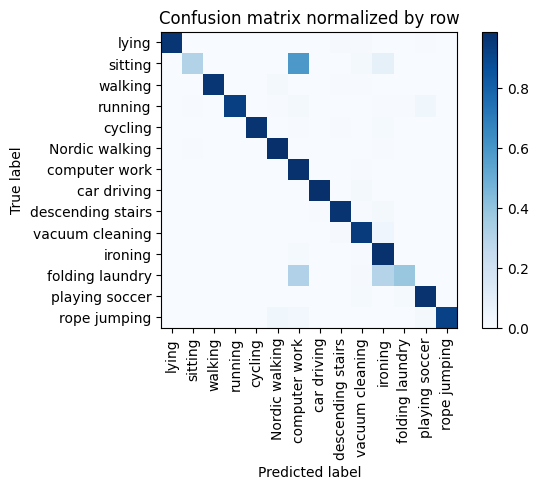

Overall accuracy: 0.885



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

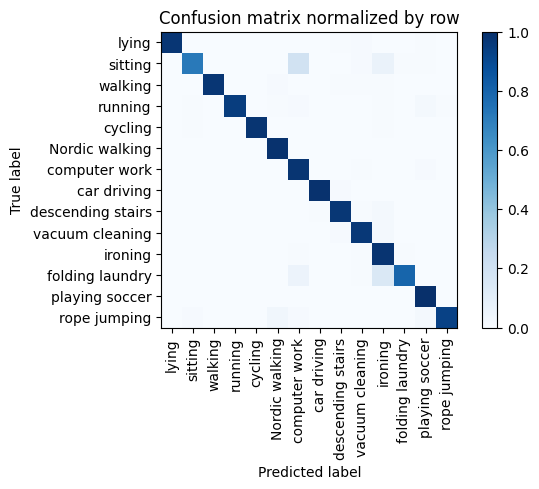

Overall accuracy: 0.946



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

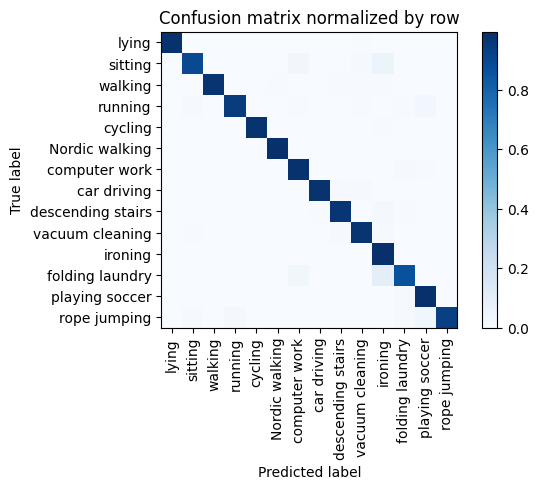

Overall accuracy: 0.968



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

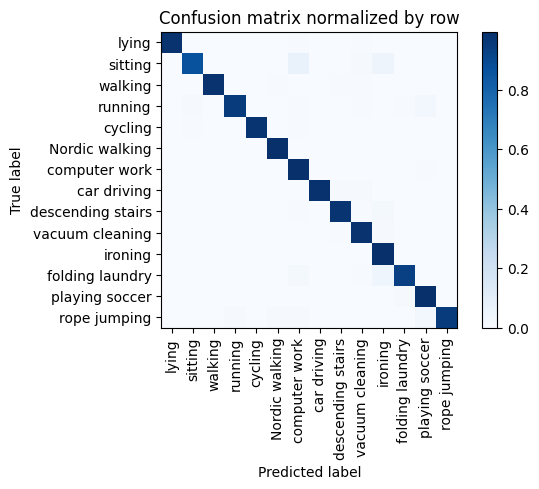

Overall accuracy: 0.969



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

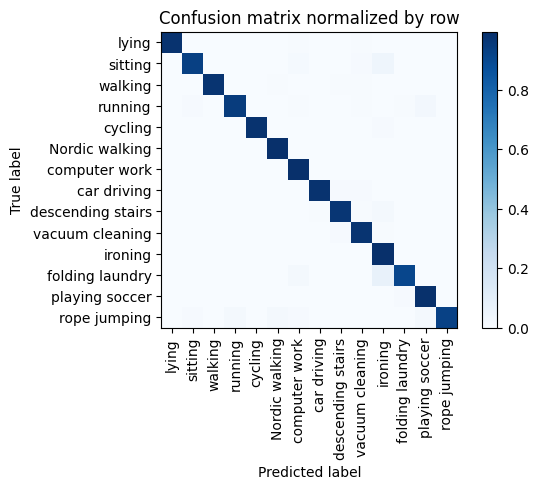

Overall accuracy: 0.975



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

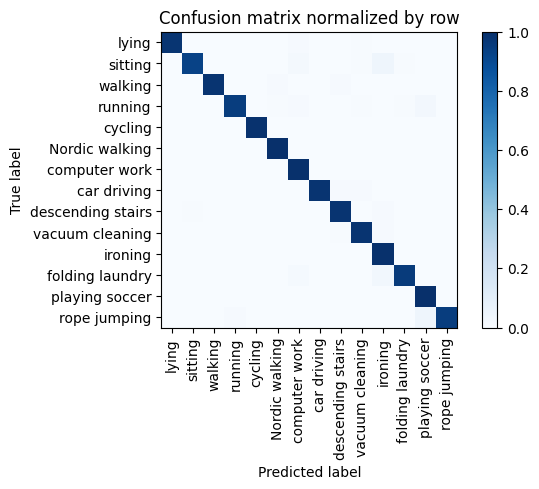

Overall accuracy: 0.979



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

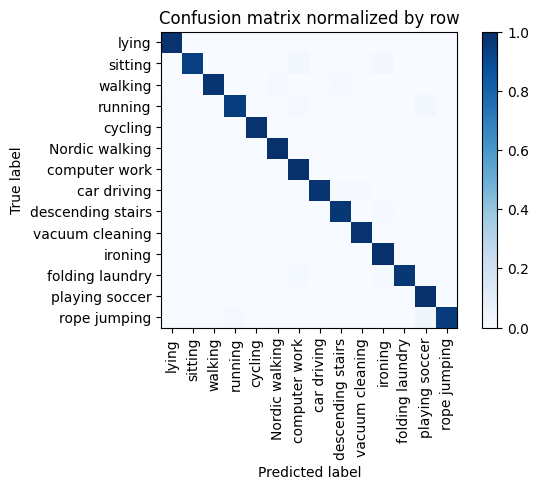

Overall accuracy: 0.981



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

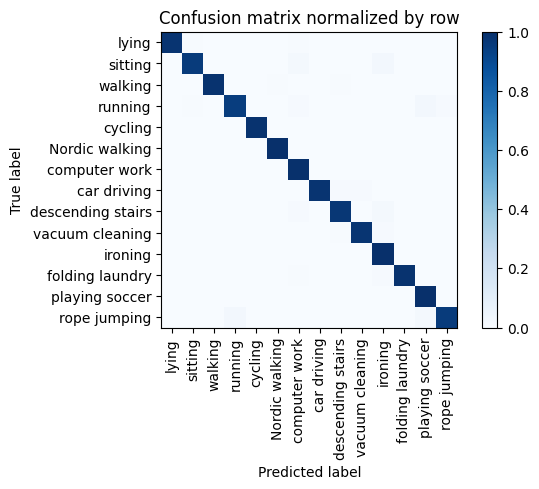

Overall accuracy: 0.983



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

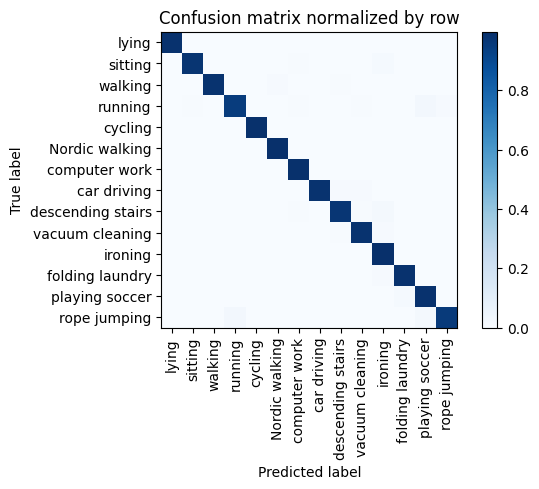

Overall accuracy: 0.985



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

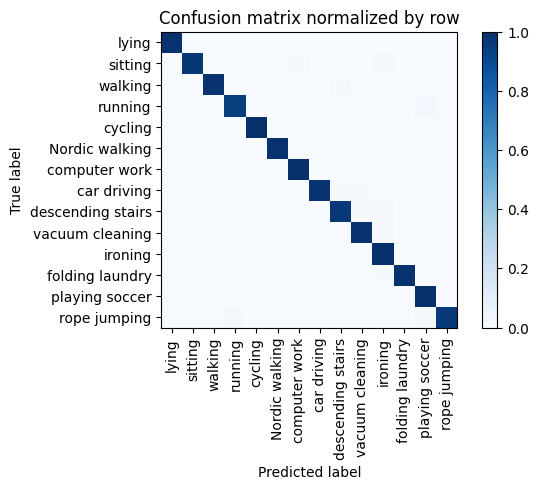

Overall accuracy: 0.986



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

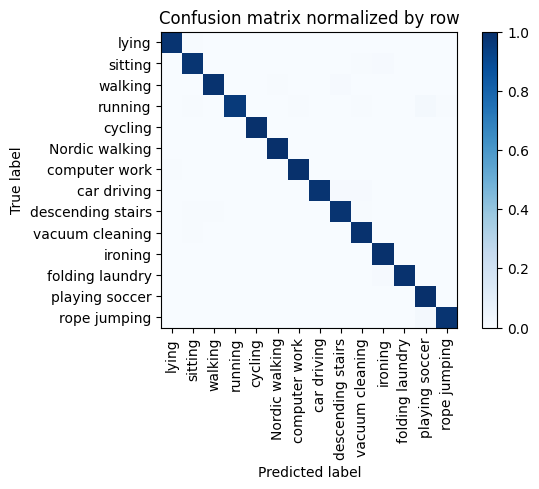

Overall accuracy: 0.988



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

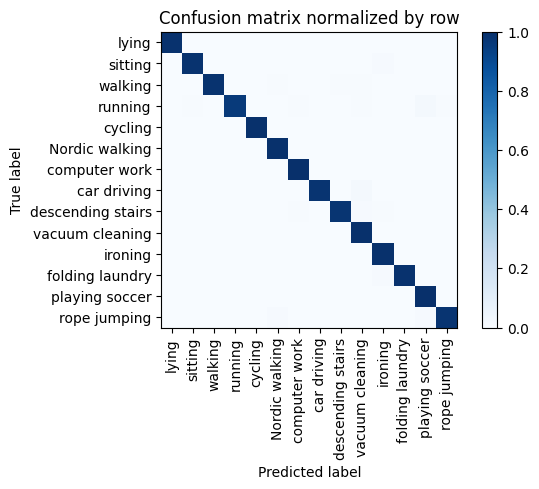

Overall accuracy: 0.990



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

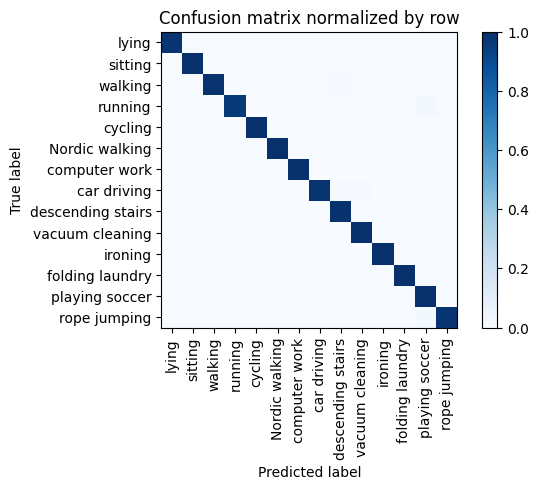

Overall accuracy: 0.990



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

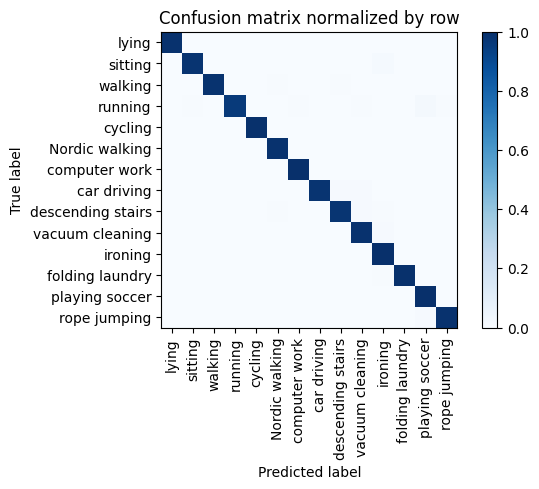

Overall accuracy: 0.990



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

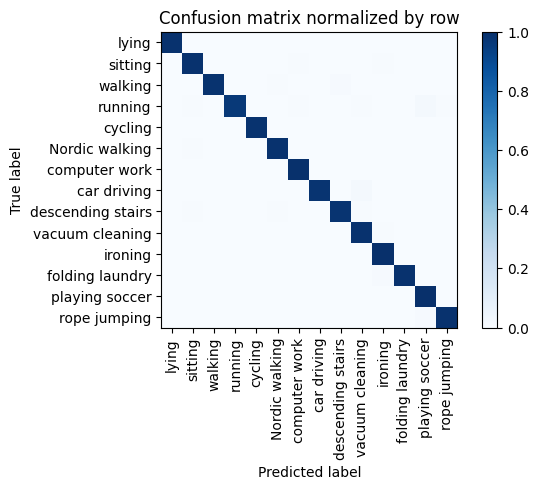

Overall accuracy: 0.990



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

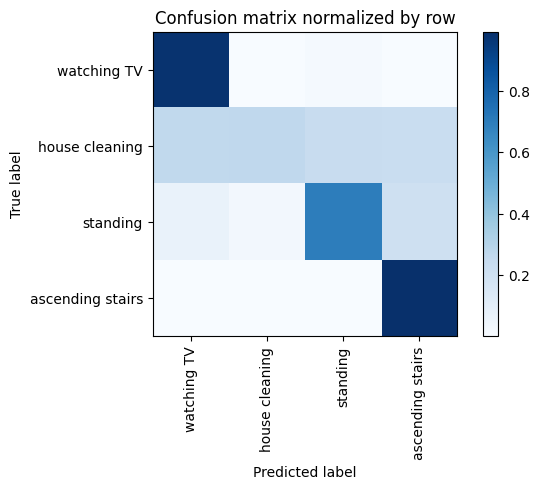

Overall accuracy: 0.653

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.739      0.696      0.717      0.331       1844|	 ascending stairs: 0.206,	watching TV: 0.071,	
  house cleaning       0.894      0.267      0.411      0.329       1831|	 watching TV: 0.264,	standing: 0.239,	
ascending stairs       0.569      0.991      0.723      0.192       1069|	 house cleaning: 0.005,	standing: 0.003,	
     watching TV       0.566      0.978      0.717      0.148        824|	 standing: 0.015,	house cleaning: 0.005,	

----------------------------------------------------------------------------------------------------
     avg / total       0.732      0.653      0.617        1.0       5568|	      

{'accuracy': 0.6531968390804598, 'precision': 0.6920326756031006, 'recall': 0.7329085485104748, 'f1': 0.6419352418217437}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending st

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

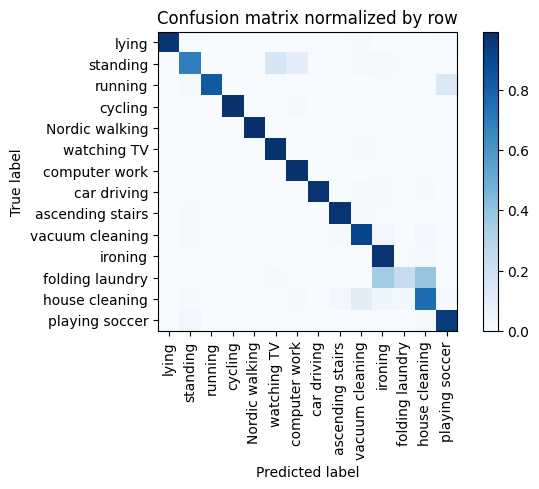

Overall accuracy: 0.883



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

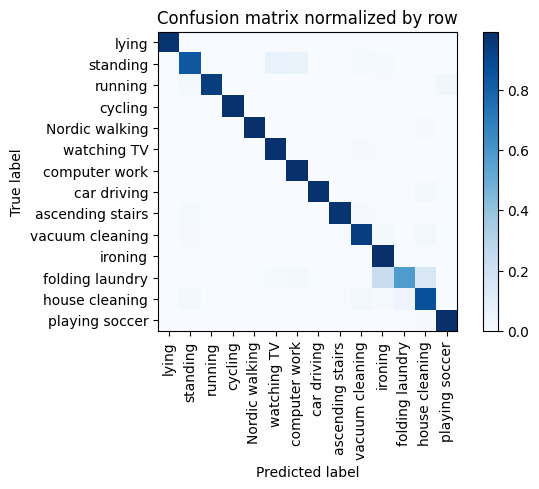

Overall accuracy: 0.935



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

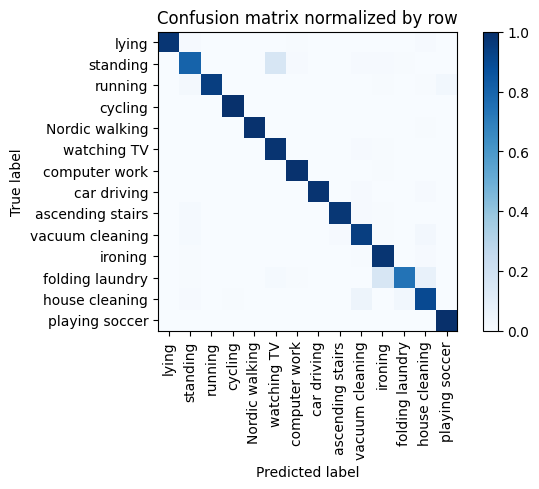

Overall accuracy: 0.943



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

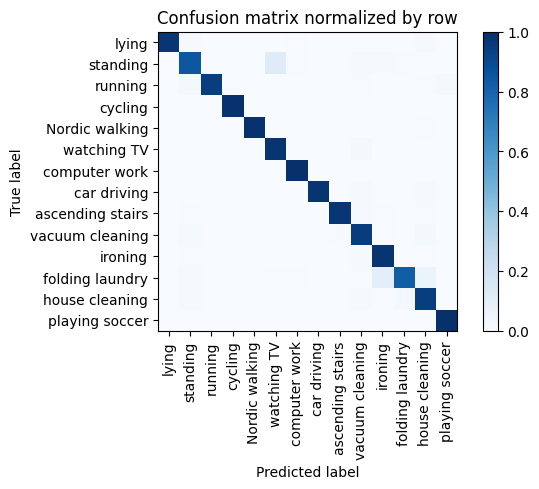

Overall accuracy: 0.957



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

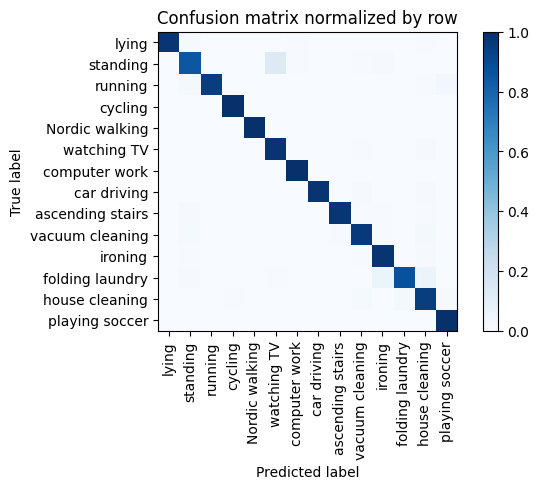

Overall accuracy: 0.960



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

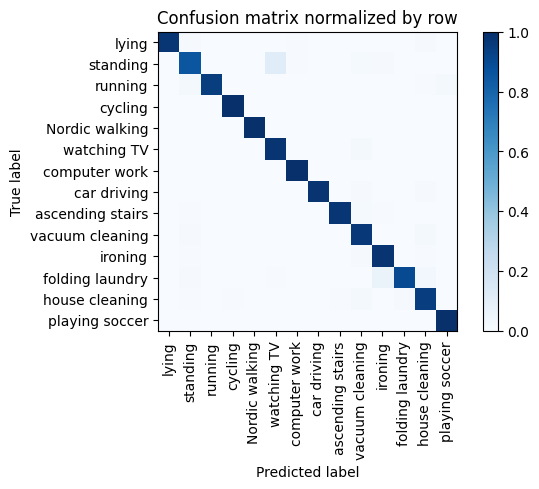

Overall accuracy: 0.963



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

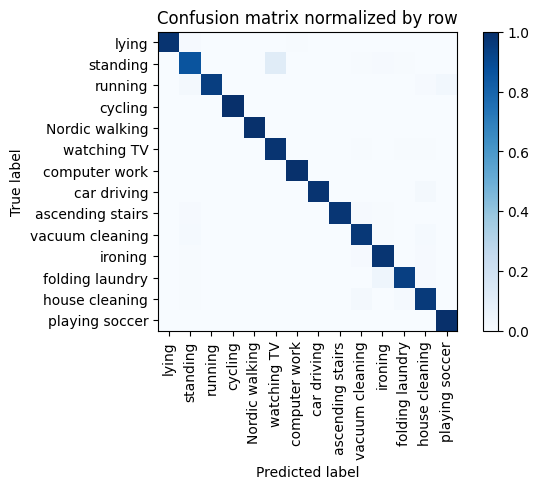

Overall accuracy: 0.968



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

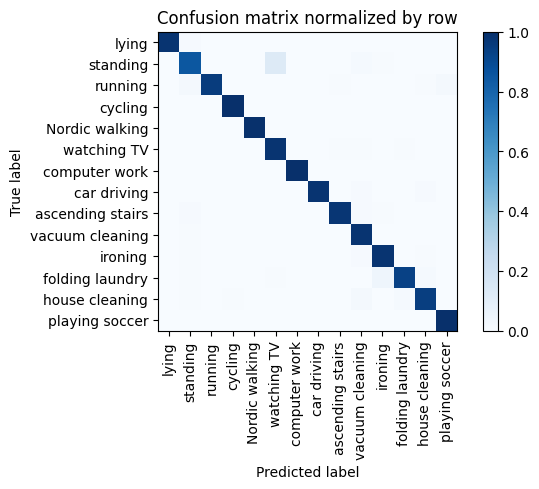

Overall accuracy: 0.967



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

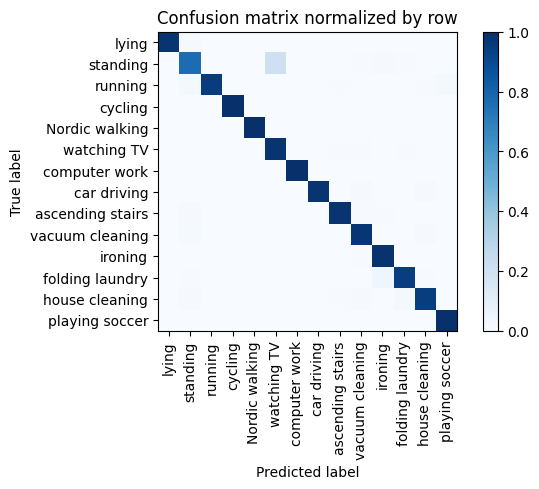

Overall accuracy: 0.959



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

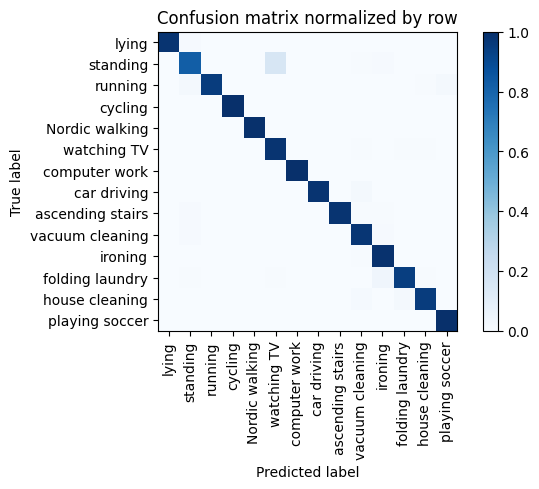

Overall accuracy: 0.967



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

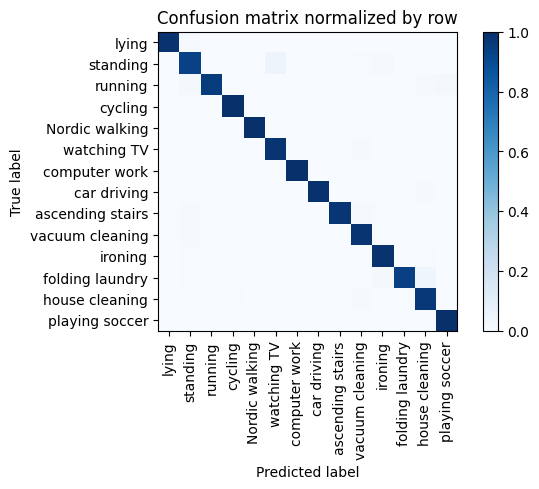

Overall accuracy: 0.978



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

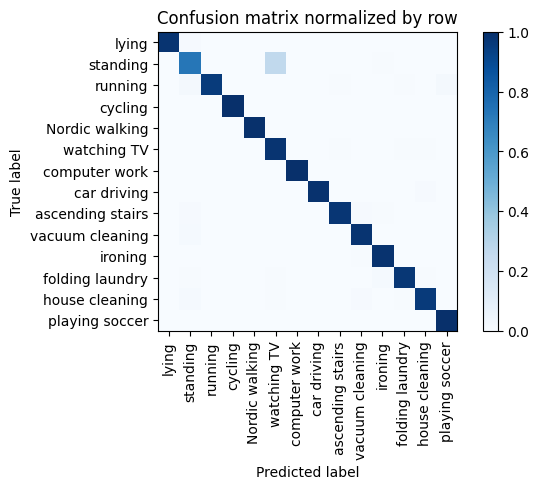

Overall accuracy: 0.959



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

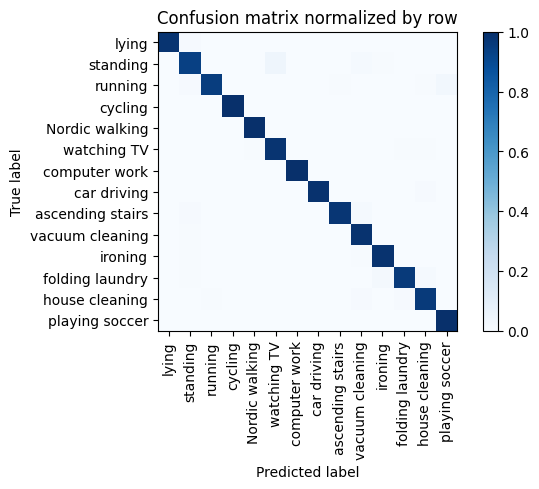

Overall accuracy: 0.980



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

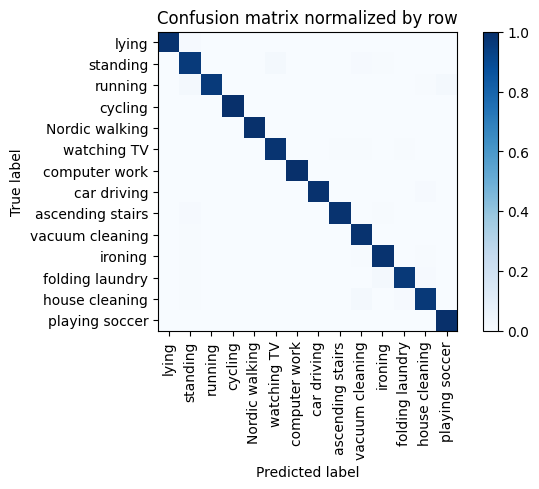

Overall accuracy: 0.983



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

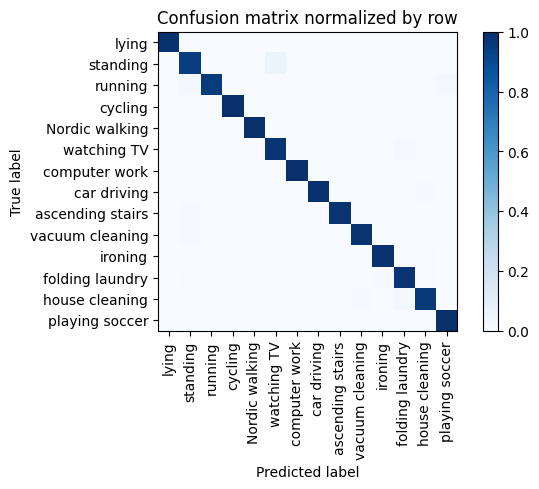

Overall accuracy: 0.982



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

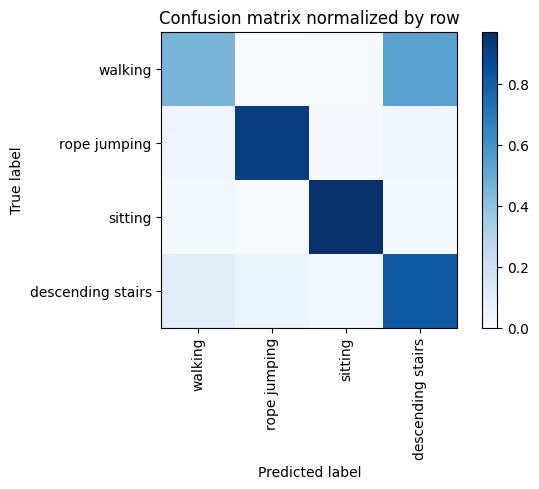

Overall accuracy: 0.725

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.877      0.456      0.600      0.419       2307|	 descending stairs: 0.540,	sitting: 0.004,	
          sitting       0.979      0.972      0.975      0.325       1790|	 walking: 0.016,	descending stairs: 0.012,	
descending stairs       0.377      0.819      0.516      0.172        947|	 walking: 0.106,	rope jumping: 0.050,	
     rope jumping       0.900      0.915      0.907      0.084        460|	 walking: 0.041,	descending stairs: 0.033,	

----------------------------------------------------------------------------------------------------
      avg / total       0.826      0.725      0.733        1.0       5504|	      

{'accuracy': 0.7247456395348837, 'precision': 0.7831200335461045, 'recall': 0.790679419091142, 'f1': 0.7497696827694124}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

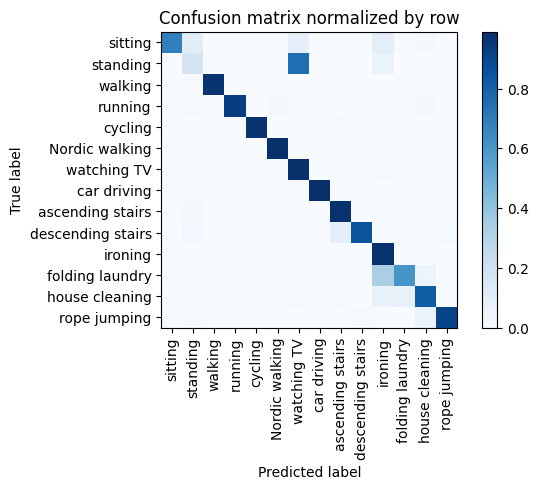

Overall accuracy: 0.832



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

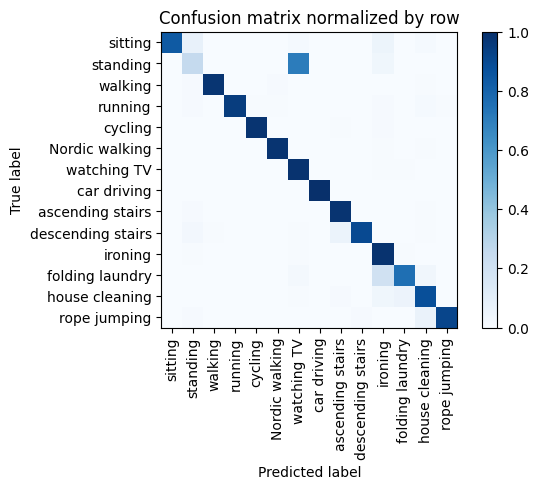

Overall accuracy: 0.872



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

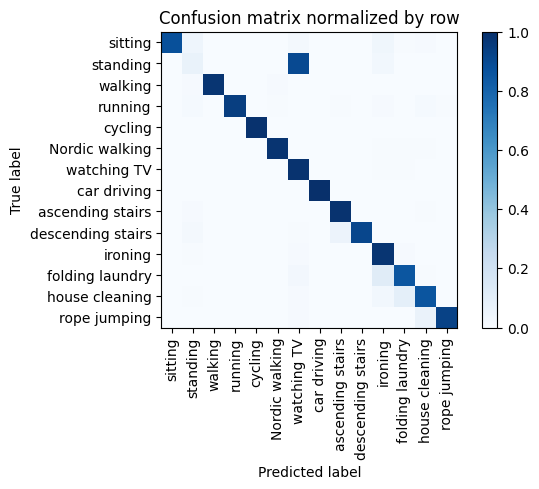

Overall accuracy: 0.862



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

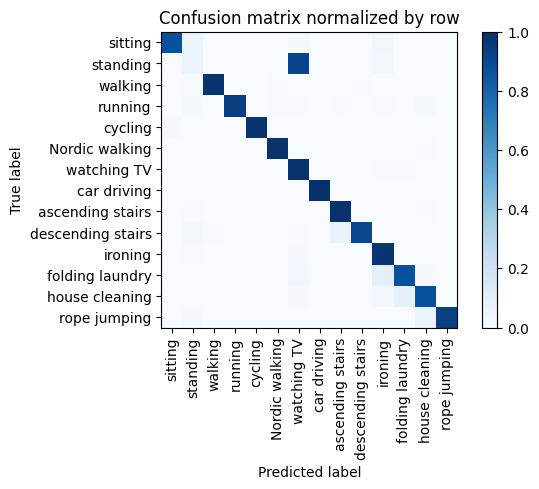

Overall accuracy: 0.863



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

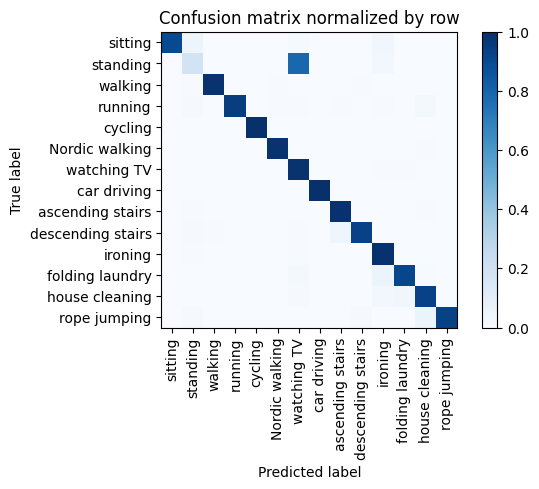

Overall accuracy: 0.889



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

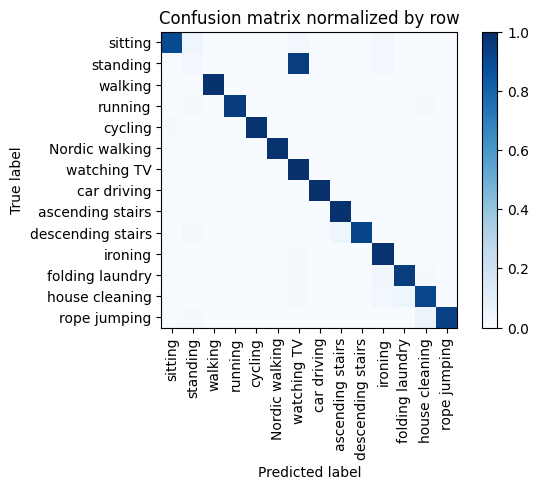

Overall accuracy: 0.872



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

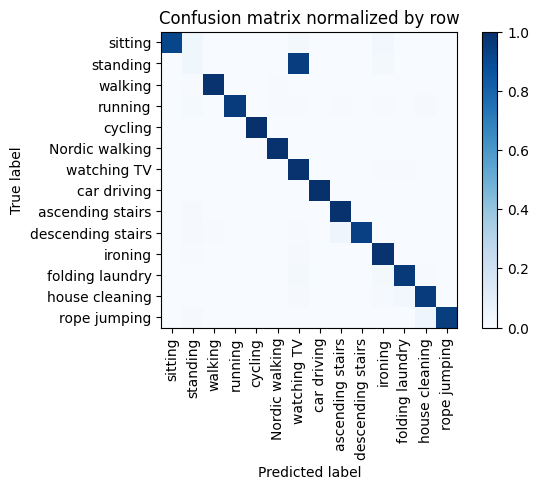

Overall accuracy: 0.881



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

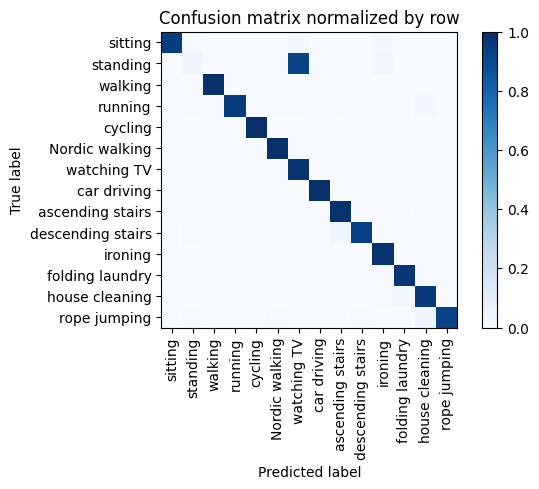

Overall accuracy: 0.888



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

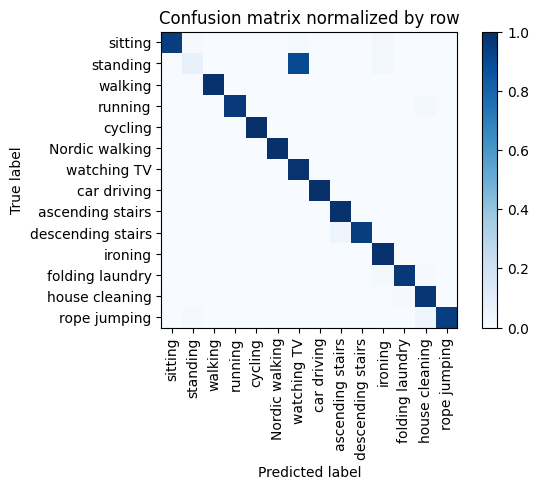

Overall accuracy: 0.892



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

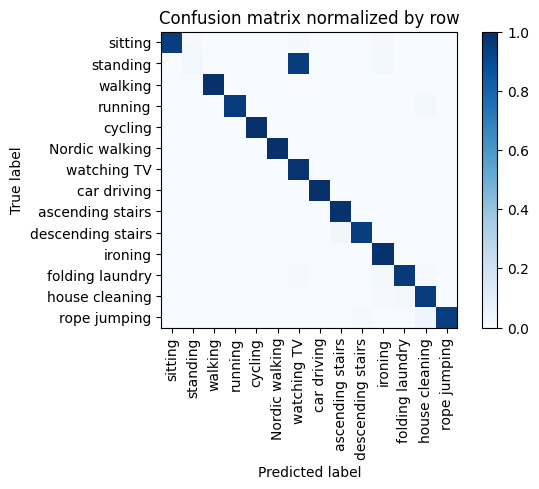

Overall accuracy: 0.887



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

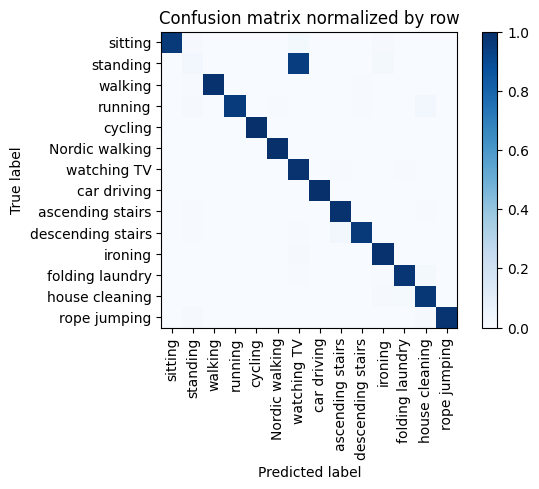

Overall accuracy: 0.891



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

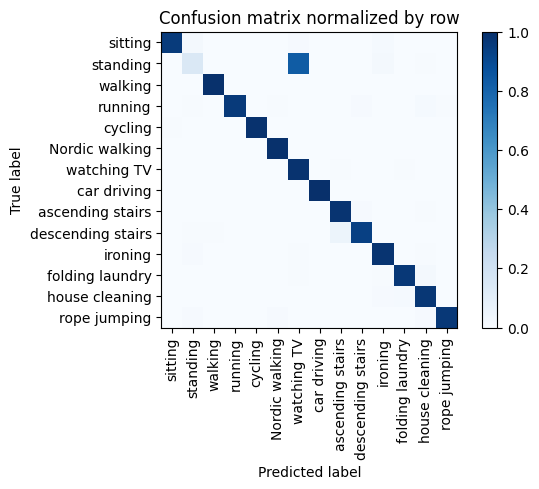

Overall accuracy: 0.900



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

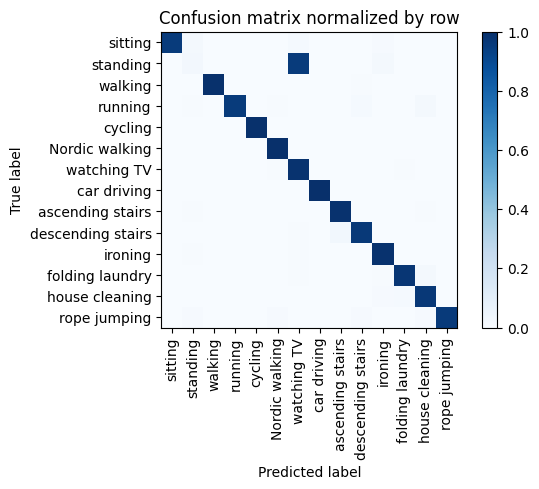

Overall accuracy: 0.891



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

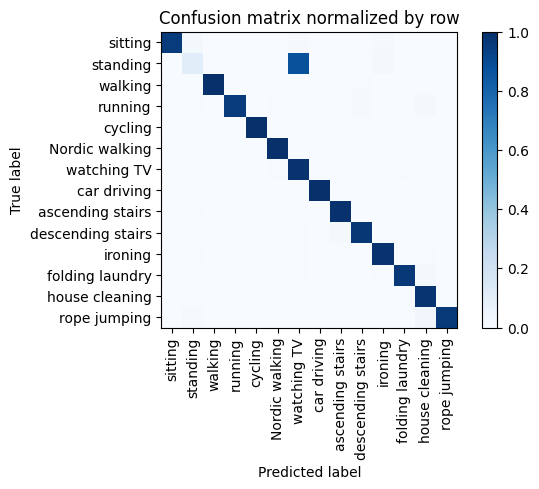

Overall accuracy: 0.899



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

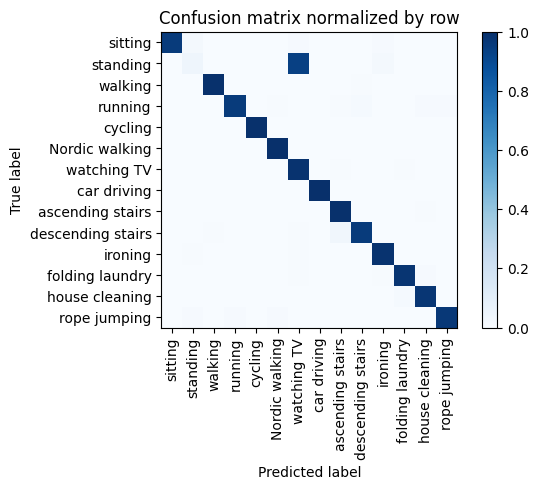

Overall accuracy: 0.893



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

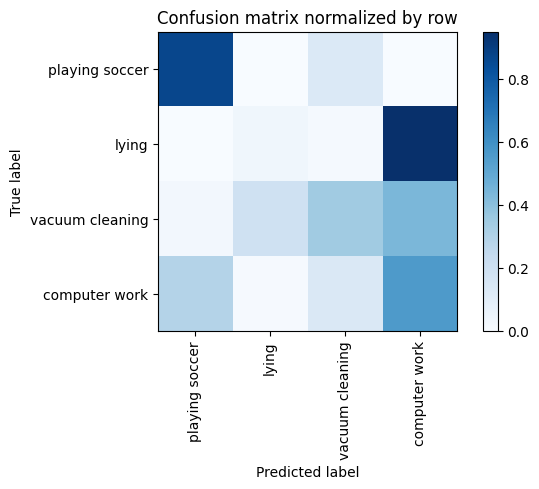

Overall accuracy: 0.390

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.405      0.560      0.470      0.432       3071|	 playing soccer: 0.292,	vacuum cleaning: 0.140,	
          lying       0.152      0.034      0.055      0.264       1874|	 computer work: 0.951,	vacuum cleaning: 0.014,	
vacuum cleaning       0.535      0.349      0.422      0.240       1702|	 computer work: 0.436,	lying: 0.192,	
 playing soccer       0.297      0.869      0.443      0.064        457|	 vacuum cleaning: 0.131,	computer work: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.363      0.390      0.347        1.0       7104|	      

{'accuracy': 0.39034346846846846, 'precision': 0.34730898170480096, 'recall': 0.45277014995303017, 'f1': 0.34760291068566207}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
p

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

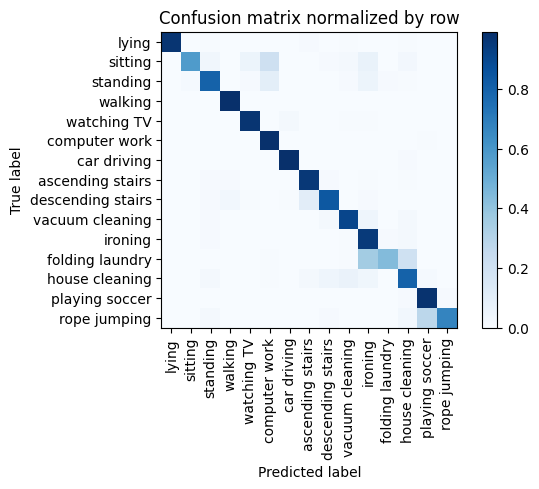

Overall accuracy: 0.869



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

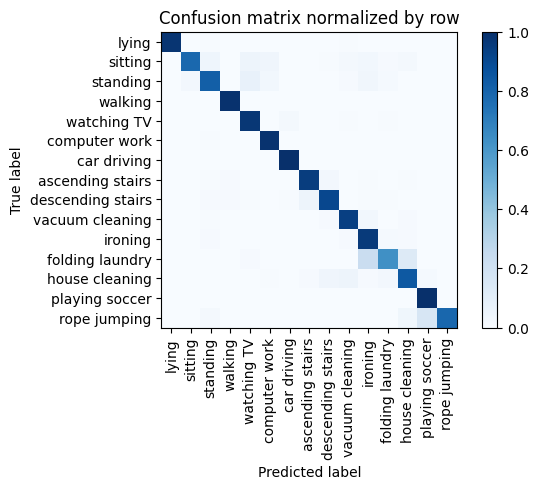

Overall accuracy: 0.911



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

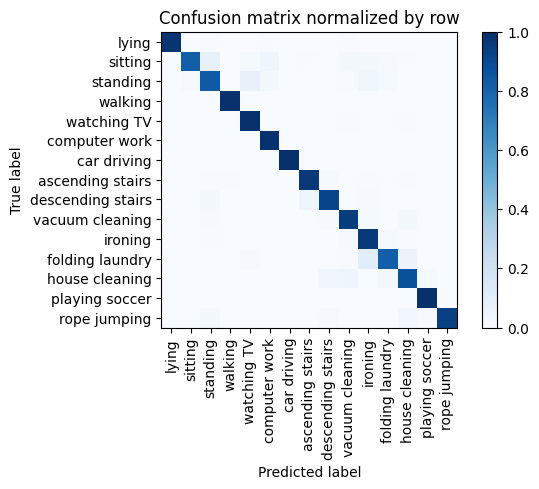

Overall accuracy: 0.934



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

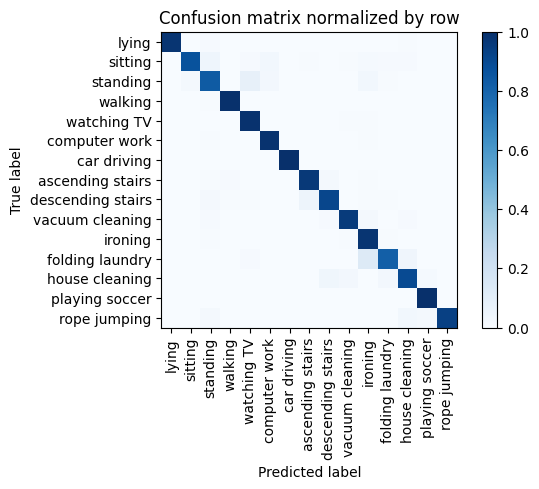

Overall accuracy: 0.941



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

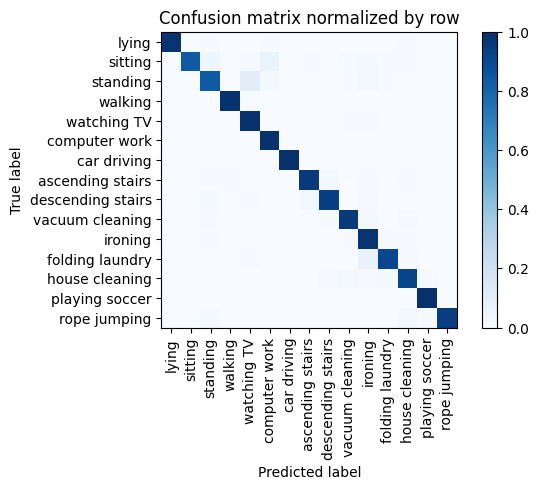

Overall accuracy: 0.946



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

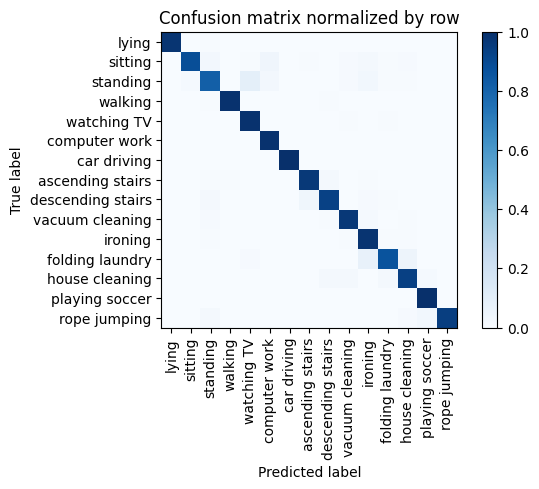

Overall accuracy: 0.949



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

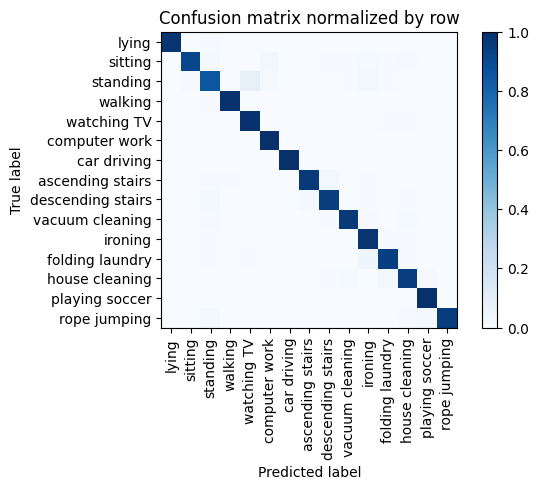

Overall accuracy: 0.959



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

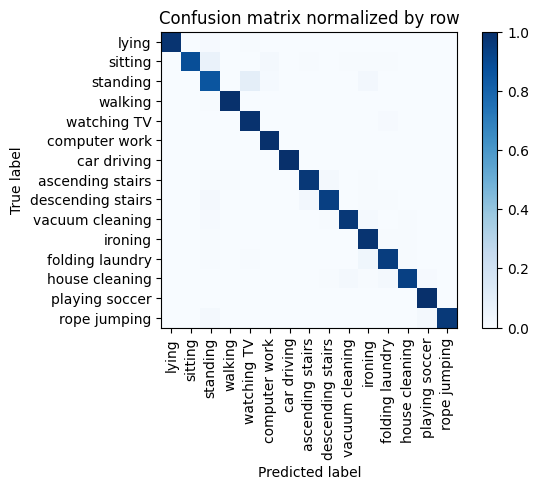

Overall accuracy: 0.958



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

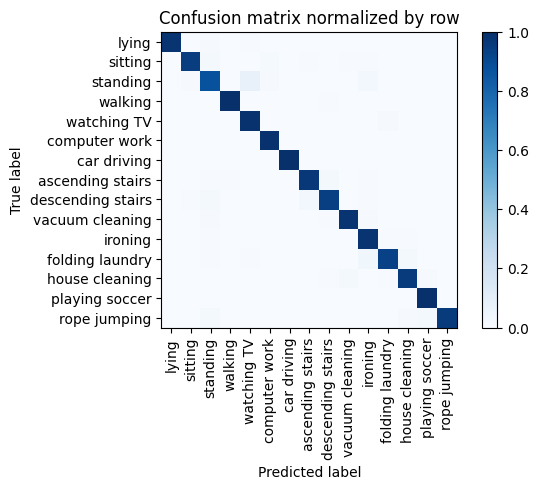

Overall accuracy: 0.966



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

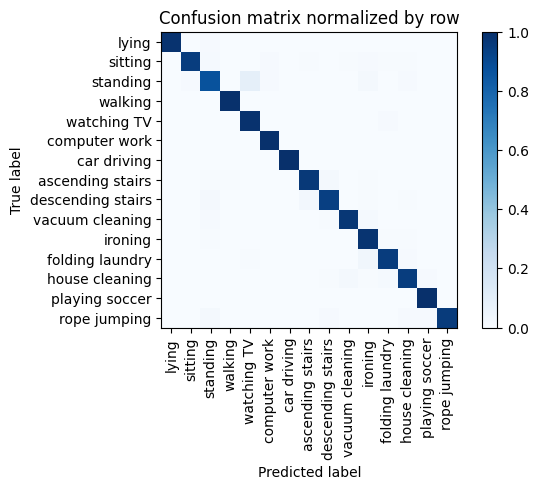

Overall accuracy: 0.966



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

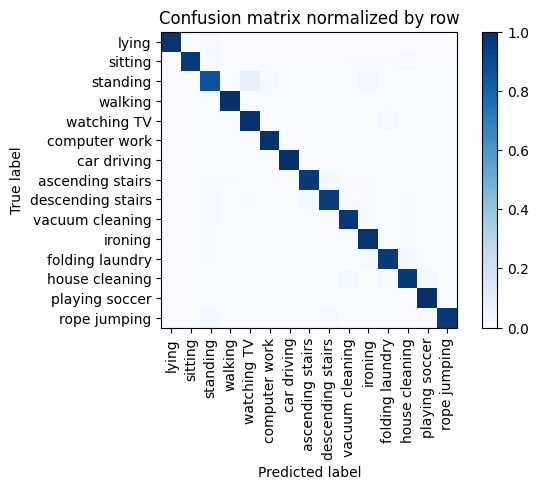

Overall accuracy: 0.969



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

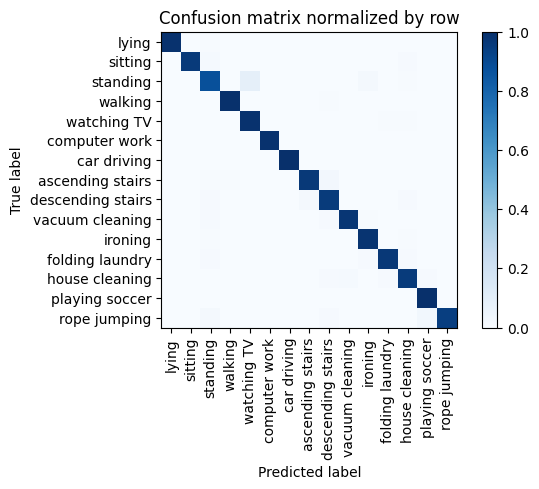

Overall accuracy: 0.970



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

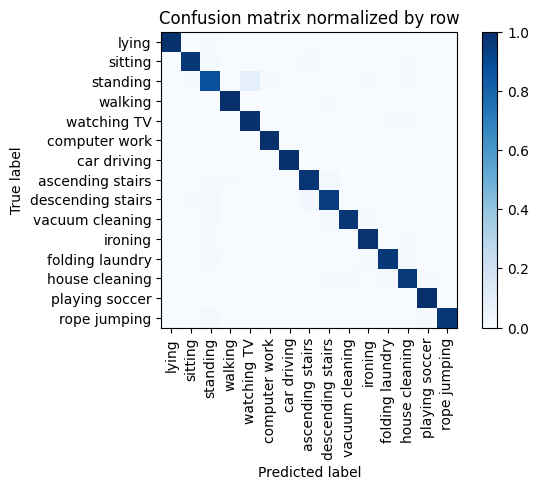

Overall accuracy: 0.971



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

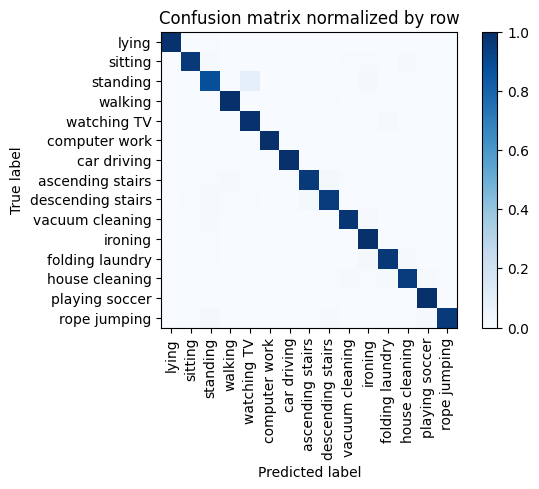

Overall accuracy: 0.972



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

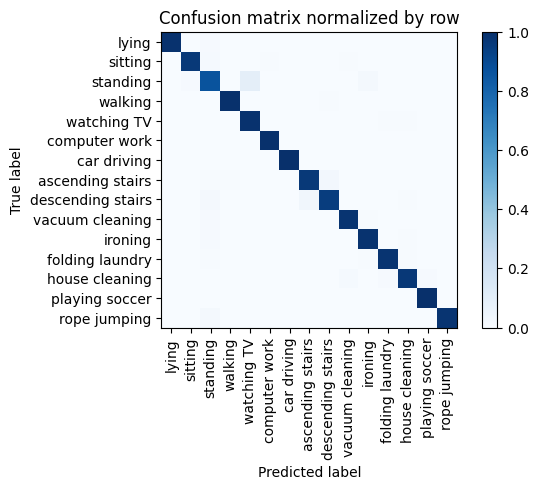

Overall accuracy: 0.972



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

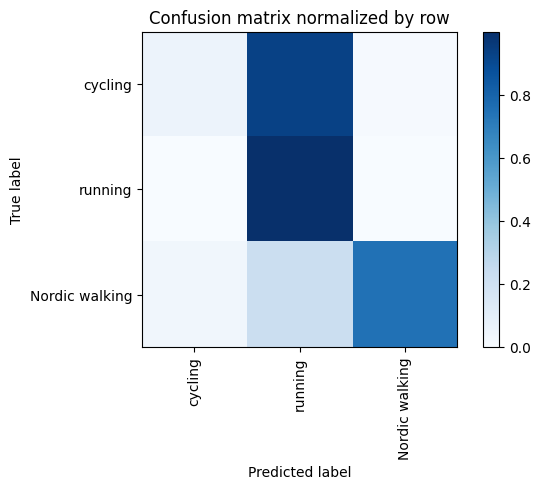

Overall accuracy: 0.550

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.988      0.747      0.851      0.419       1823|	 running: 0.219,	cycling: 0.035,	
       cycling       0.592      0.058      0.106      0.365       1590|	 running: 0.931,	Nordic walking: 0.010,	
       running       0.333      0.999      0.499      0.216        939|	 cycling: 0.001,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.702      0.550      0.503        1.0       4352|	      

{'accuracy': 0.5496323529411765, 'precision': 0.6378658032754227, 'recall': 0.601332396203463, 'f1': 0.4854759355709068}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'com

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

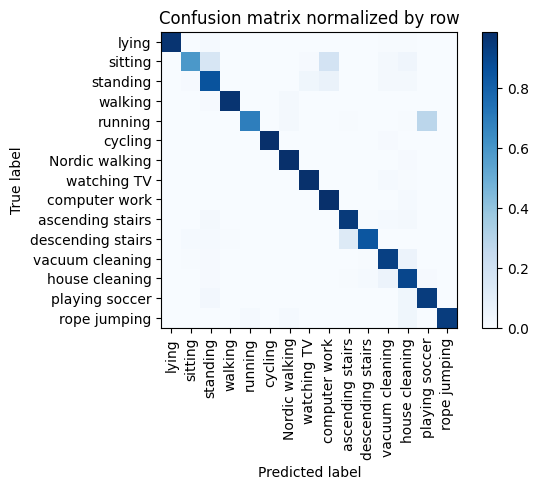

Overall accuracy: 0.904



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

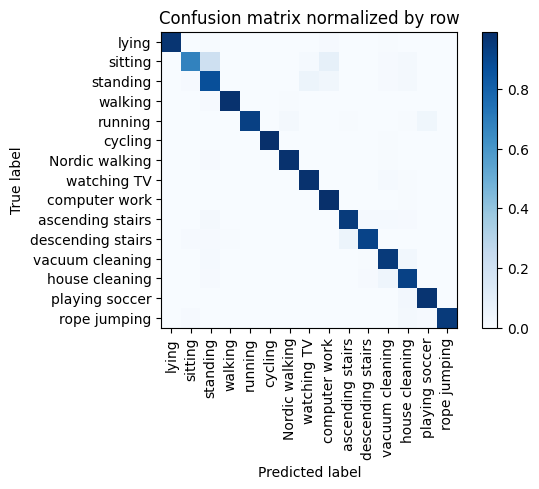

Overall accuracy: 0.935



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

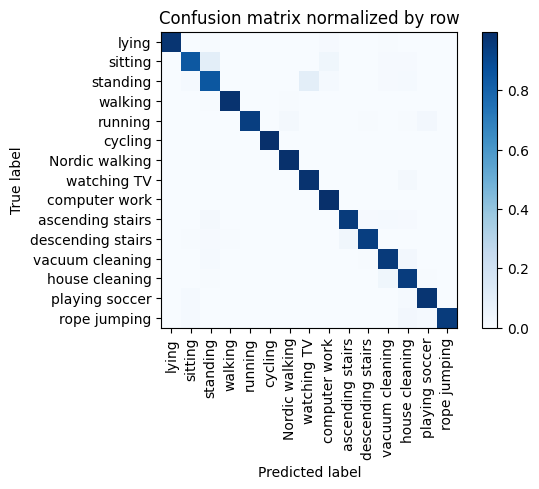

Overall accuracy: 0.952



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

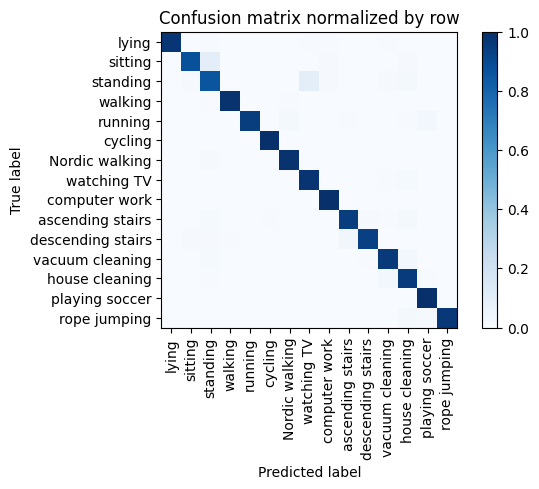

Overall accuracy: 0.956



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

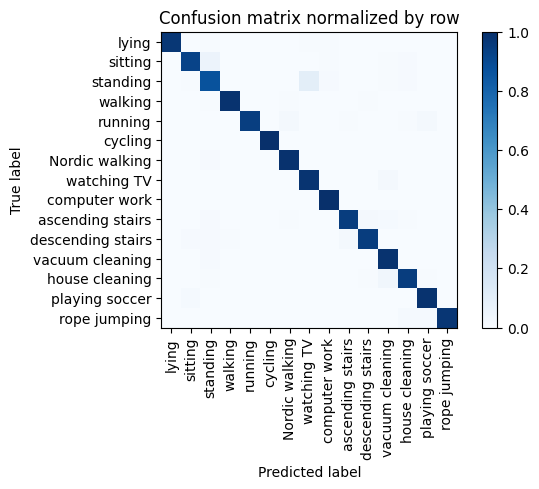

Overall accuracy: 0.964



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

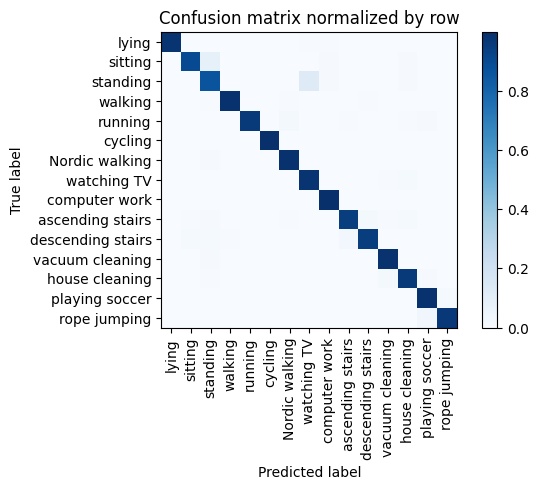

Overall accuracy: 0.963



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

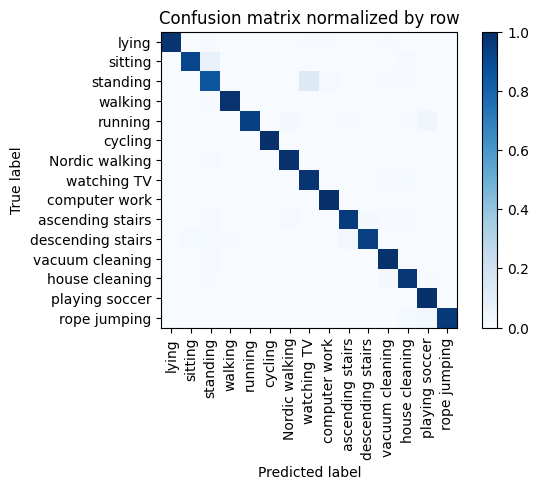

Overall accuracy: 0.965



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

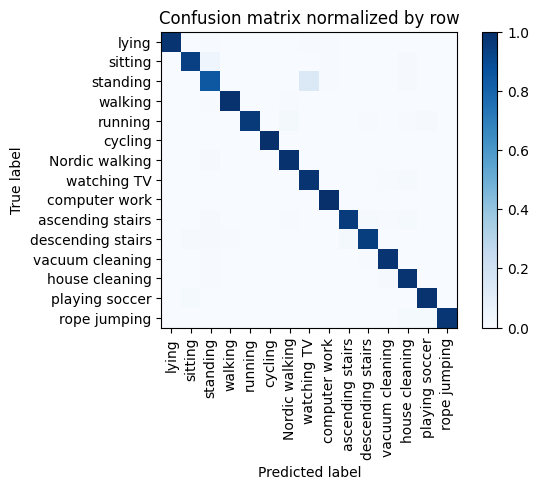

Overall accuracy: 0.968



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

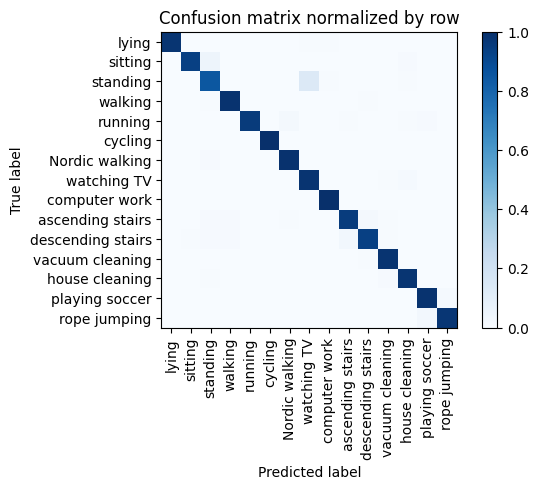

Overall accuracy: 0.967



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

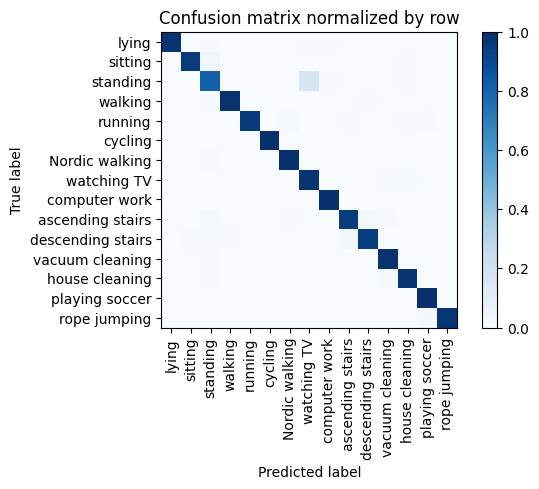

Overall accuracy: 0.966



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

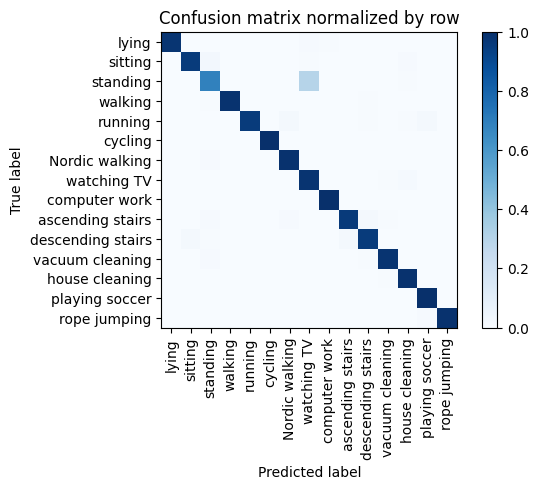

Overall accuracy: 0.958



train:   0%|          | 0/283 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("=" * 16, f'Fold-{i}', "=" * 16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'],
                                    unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21,
                                    resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat,
                             attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'],
                            attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat,
                            attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)

    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt, optimizer, loss_module, device,
                                   class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        eval_metrics = eval_step(model, eval_dl, eval_dt, loss_module, device,
                                 class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=False,
                                 loss_alpha=0.0001)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model, notebook_iden, model_iden, i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, test_dt, loss_module, device,
                             class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("=" * 40)

print("=" * 14, "Overall Unseen Classes Performance", "=" * 14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
